In [72]:
import os
from os.path import expanduser
import socket
import sys
import glob

# BELOW IS SYSTEM/PATH CONFIGURATION #
my_home = expanduser("~")
running_system = socket.gethostname()
# Configure machine's names here #
systemHLRN = 'blogin1'
systemLOCAL = 'Laurents-MacBook-Pro.local'
my_home = expanduser("~")
# Define local pass #
wd_path = '/home/hbkoziel/pyfesom/'
save_path = wd_path+'/figures/Arc12/FINAL/'

#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append('../..') # add standard 's modules
sys.path.append(wd_path)
#########################################

In [73]:
import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time

import xarray as xr
import pandas as pd

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap

In [74]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
meshpath   = '/home/hbkoziel/pyfesom/data/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=True)                                    # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative

tracername = 'LIM'
first_year = 1985
last_year  = 2015
years      = np.arange(first_year,last_year+1,1)
runid	= 'Arc12'

data_path  = '/scratch/usr/hbkoziel/'+runid+'/netcdf/'

/home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /home/hbkoziel/pyfesom/data/mesh/meshArc4.5/pickle_mesh


In [97]:
dates = pd.date_range('1985', freq="M", periods= 12*len(np.arange(1985,2016,1)))
data = xr.open_mfdataset(data_path+tracername+'*.nc', concat_dim='time')
data['time'] = dates
#data.time.data = dates

In [98]:
data

<xarray.Dataset>
Dimensions:            (nod2d: 753179, time: 372)
Coordinates:
  * time               (time) datetime64[ns] 1985-01-31 ... 2015-12-31
Dimensions without coordinates: nod2d
Data variables:
    Felimphy           (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Felimdia           (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Nlimphy            (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Nlimdia            (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Silim              (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Phy_Light_limiter  (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
    Dia_Light_limiter  (time, nod2d) float64 dask.array<shape=(372, 753179), chunksize=(12, 753179)>
Attributes:
    description:  Photosynthesis Limiting factors
    history:      Created 

In [99]:
data2 = data.sel(time=data.time.dt.month.isin([4, 5, 6, 7, 8, 9]))
data2 = data2.compute()
data2

<xarray.Dataset>
Dimensions:            (nod2d: 753179, time: 186)
Coordinates:
  * time               (time) datetime64[ns] 1985-04-30 ... 2015-09-30
Dimensions without coordinates: nod2d
Data variables:
    Felimphy           (time, nod2d) float64 0.744 0.6865 ... 0.9357 0.937
    Felimdia           (time, nod2d) float64 0.3263 0.2674 ... 0.7081 0.7125
    Nlimphy            (time, nod2d) float64 0.9802 0.98 0.9797 ... 0.983 0.9832
    Nlimdia            (time, nod2d) float64 0.9646 0.9642 ... 0.9695 0.9698
    Silim              (time, nod2d) float64 0.9361 0.9339 ... 0.9355 0.9367
    Phy_Light_limiter  (time, nod2d) float64 2.512e-05 4.539e-05 ... 0.0003897
    Dia_Light_limiter  (time, nod2d) float64 0.0001954 0.0003864 ... 4.373e-05
Attributes:
    description:  Photosynthesis Limiting factors
    history:      Created Thu Jan  7 11:32:03 2021

In [100]:
data_np = data2.Nlimphy.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_np = data_np.compute()

data_nd = data2.Nlimdia.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_nd = data_nd.compute()

data_si = data2.Silim.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_si = data_si.compute()

data_lp = data2.Phy_Light_limiter.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_lp = data_lp.compute()

data_ld = data2.Dia_Light_limiter.sel(time=slice(str(first_year)+'-01-01', str(last_year)+'-12-31'))
data_ld = data_ld.compute()

In [101]:
ncfile      = meshpath+'Arc4.5.initial.mesh.diag.nc'
f           = Dataset(ncfile, 'r')
NodalAreaModel = f.variables['cluster_area'][:]

In [159]:
data_np_mean = data_np.resample(time='YS').mean(dim='time')
data_nd_mean = data_nd.resample(time='YS').mean(dim='time')
data_si_mean = data_si.resample(time='YS').mean(dim='time')

data_lim_sertemp = 100 - 100*(data_np_mean + data_nd_mean + data_si_mean)/3
data_lim_mean = data_lim_sertemp.mean(dim='time')
pff = np.polyfit(years, data_lim_sertemp, 1)
data_lim_trend = pff[0]

In [160]:
print data_lim_mean.shape
print data_lim_trend.shape
print data_lim_sertemp.shape

(753179,)
(753179,)
(31, 753179)


For depth 0 model level -0.0 will be used


Text(0.5,1,'Nutrient limitation')

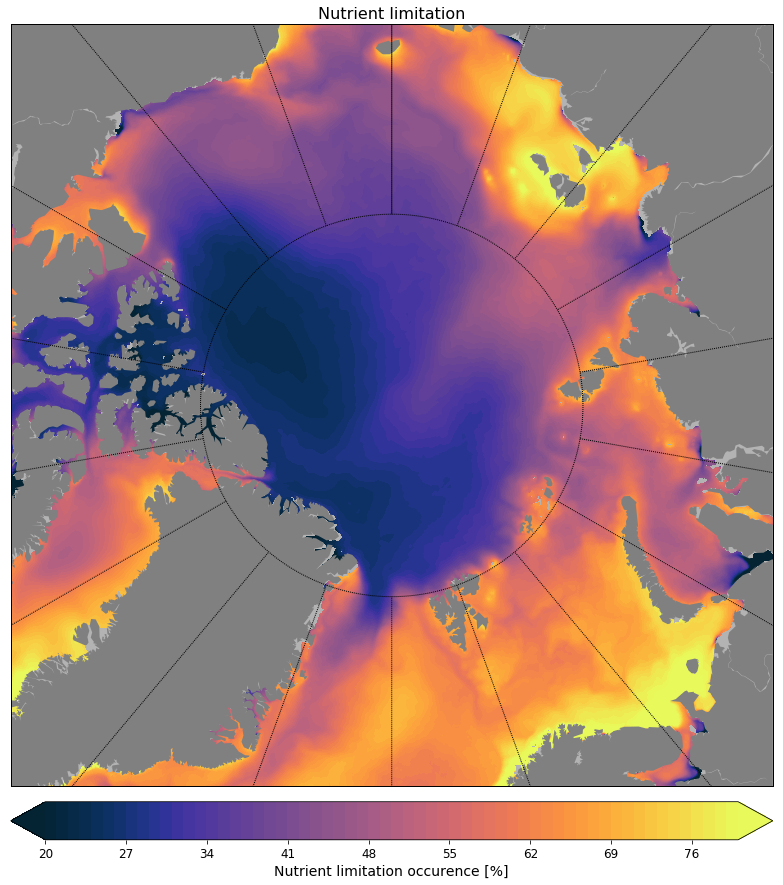

In [161]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

#MLD_sept_mean[MLD_sept_mean == 0] = np.nan
data, elem_no_nan = pf.get_data(data_lim_mean,mesh,0)
ax1      = fig.add_subplot(111)
contours = np.arange(20, 81, 1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.thermal, extend='both')
label = 'Nutrient limitation occurence [%]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.title('Nutrient limitation', fontsize=16)

For depth 0 model level -0.0 will be used


Text(0.5,1,'Nutrient limitation trend')

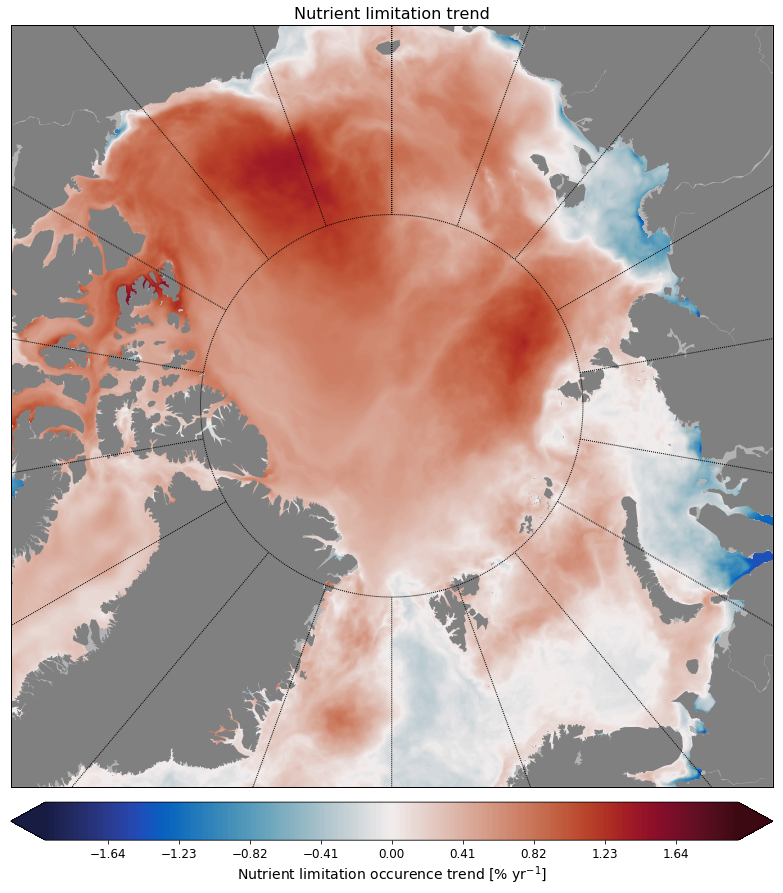

In [155]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

#MLD_sept_mean[MLD_sept_mean == 0] = np.nan
data, elem_no_nan = pf.get_data(data_lim_trend,mesh,0)
ax1      = fig.add_subplot(111)
contours = np.arange(-2, 2.01, .01)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'Nutrient limitation occurence trend [% yr$^{-1}$]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.title('Nutrient limitation trend', fontsize=16)

In [156]:
data_lp_mean = data_lp.resample(time='YS').mean(dim='time')
data_ld_mean = data_ld.resample(time='YS').mean(dim='time')

data_lim_sertemp = 100 - 100*(data_lp_mean + data_ld_mean)/2
data_lim_mean = data_lim_sertemp.mean(dim='time')
pff = np.polyfit(years, data_lim_sertemp, 1)
data_lim_trend = pff[0]

For depth 0 model level -0.0 will be used


Text(0.5,1,'Light limitation occurence [%]')

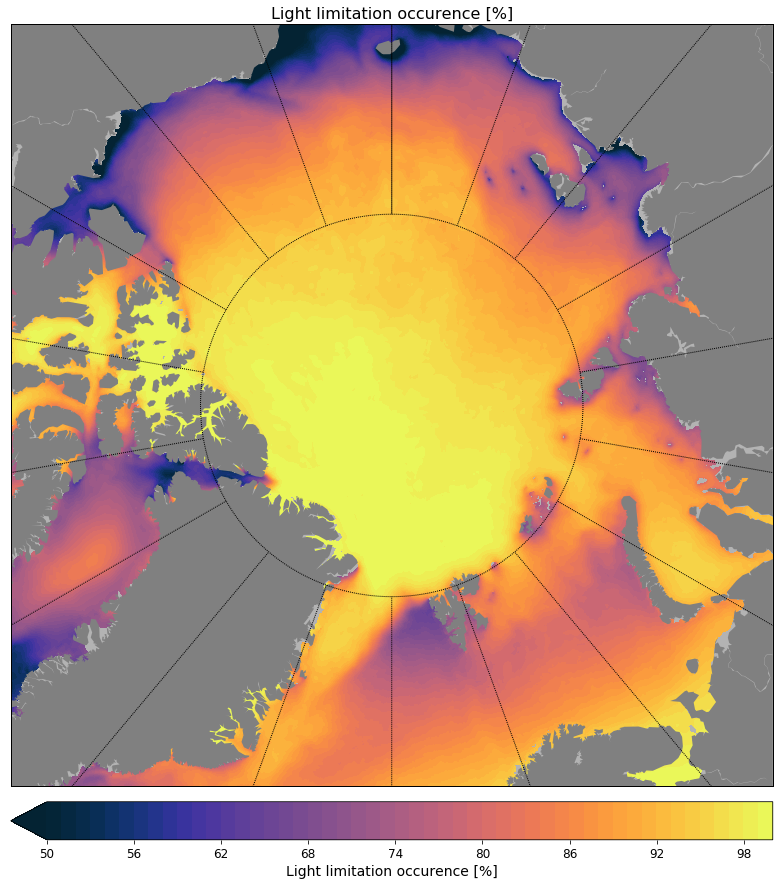

In [157]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

#MLD_sept_mean[MLD_sept_mean == 0] = np.nan
data, elem_no_nan = pf.get_data(data_lim_mean,mesh,0)
ax1      = fig.add_subplot(111)
contours = np.arange(50, 101, 1)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.thermal, extend='min')
label = 'Light limitation occurence [%]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.title('Light limitation occurence [%]', fontsize=16)

For depth 0 model level -0.0 will be used


Text(0.5,1,'Light limitation occurence trend [% yr$^{-1}$]')

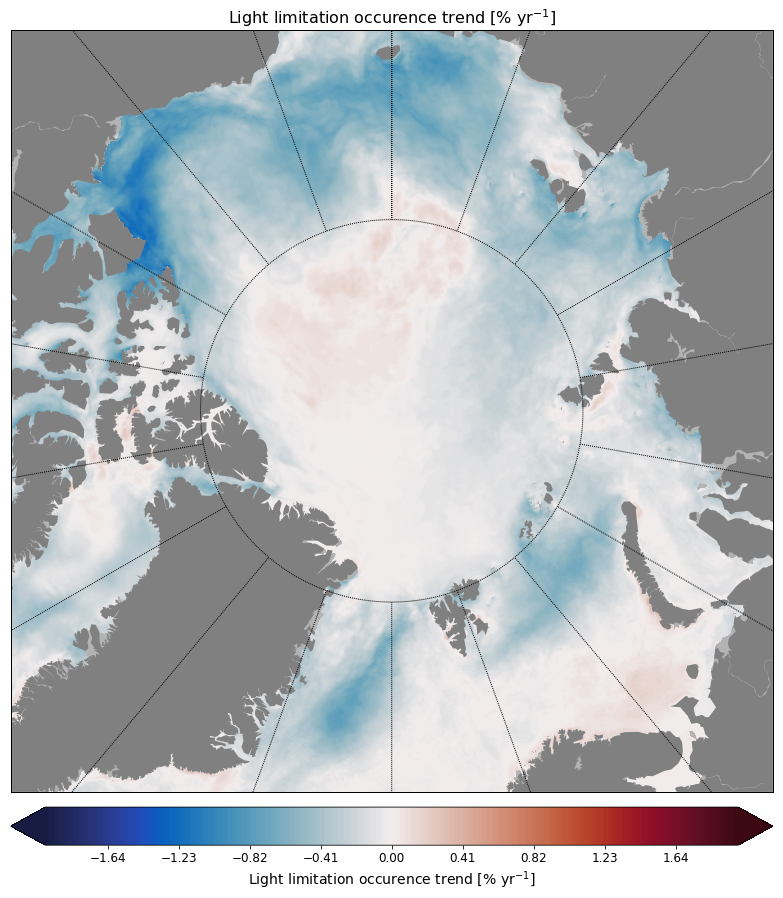

In [158]:
fig = plt.figure(figsize=(15, 15), facecolor='w', edgecolor='k')

#MLD_sept_mean[MLD_sept_mean == 0] = np.nan
data, elem_no_nan = pf.get_data(data_lim_trend,mesh,0)
ax1      = fig.add_subplot(111)
contours = np.arange(-2, 2.01, .01)
m = Basemap(projection='nplaea',boundinglat=70,lon_0=0,resolution='l')
x, y = m(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
m.drawmapboundary(fill_color='0.7')
m.fillcontinents(color='.5',lake_color='.7')
im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
label = 'Light limitation occurence trend [% yr$^{-1}$]'
cbar=m.colorbar(im,"bottom", size="5%", pad="2%")
cbar.set_label(label, fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.title('Light limitation occurence trend [% yr$^{-1}$]', fontsize=16)